In [3]:
"""
I changed the Python script to this Notebook.. and updated the code a bit..
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
import numpy as np
import spacy
import requests

In [4]:
# can be changed to "en_core_web_sm", if needed
nlp = spacy.load("en_core_web_lg")

In [5]:
# SPARQL query to get the abstract of Isaac Newton from DBPedia
endpoint_url = "http://dbpedia.org/sparql"
query = '''
    SELECT *
    WHERE {
            ?scientist  rdfs:label      "Isaac Newton"@en ;
            dbo:abstract  ?abstarct .
            FILTER ( LANG ( ?abstarct ) = 'en' )
        }
'''

r = requests.get(endpoint_url, params = {'format': 'json', 'query': query})
data = r.json()

In [6]:
text = data["results"]["bindings"][0]["abstarct"]["value"]
doc = nlp(text)

In [7]:
# Create a list of sentences from the abstract
document = []
for sent in doc.sents:
    document.append(sent.text)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
A = vectorizer.fit_transform(document).toarray()

# Create a TruncatedSVD model with 4 components
svd = TruncatedSVD(n_components=4, n_iter=7, random_state=42)
matrix = svd.fit(A)

topic_results = vectorizer.transform(document)
topic_results = svd.transform(topic_results)
tarr = topic_results.argmax(axis=1)

In [8]:
# Get the topics..
topics_in_order = []
used_topic = []
for topic in tarr:
    if topic not in used_topic:
        used_topic.append(topic)
        indexArr = np.where(tarr == topic)
        indexArr = indexArr[0]
        
        for i in indexArr:
            topics_in_order.append((document[i], topic))


In [9]:
# sort topic
topics_in_order.sort(key=lambda x: x[1])

# print the topics..
topic_printed = -1
for i in topics_in_order[1:]:
    if i[1] > topic_printed:
        print(f"--- TOPIC {i[1]+1}---")
        topic_printed = i[1]
    print(i[0])

--- TOPIC 1---
He was a key figure in the philosophical revolution known as the Enlightenment.
His book Philosophiæ Naturalis Principia Mathematica (Mathematical Principles of Natural Philosophy), first published in 1687, established classical mechanics.
Newton built the first practical reflecting telescope and developed a sophisticated theory of colour based on the observation that a prism separates white light into the colours of the visible spectrum.
His work on light was collected in his highly influential book Opticks, published in 1704.
Beyond his work on the mathematical sciences, Newton dedicated much of his time to the study of alchemy and biblical chronology, but most of his work in those areas remained unpublished until long after his death.
--- TOPIC 2---
Newton was a fellow of Trinity College and the second Lucasian Professor of Mathematics at the University of Cambridge.
Newton was a devout but unorthodox Christian who privately rejected the doctrine of the Trinity.
He re

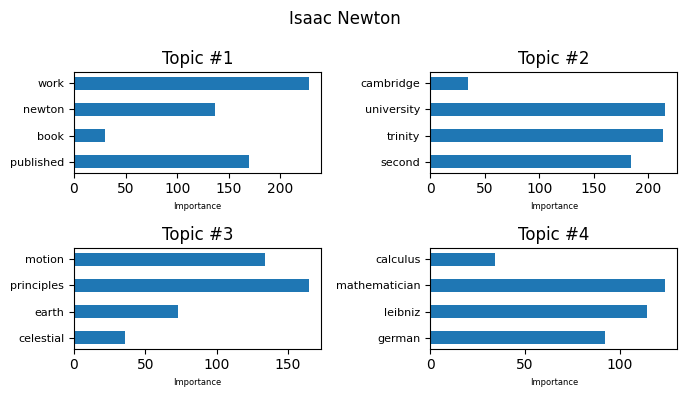

In [31]:
# Top 4 words for each topic
plt.subplots(figsize=(7,4))
plt.suptitle('Isaac Newton', fontsize=12)
plt.axis('off')
for index, topic in enumerate(matrix.components_):
    plt.subplot(2,2,index+1)
    plt.barh(np.arange(4), topic.argsort()[-4:], height=0.5)
    plt.yticks(np.arange(4), [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-4:]], fontsize=8)
    plt.title(f'Topic #{index+1}')
    plt.xlabel("Importance",fontsize=6)
    plt.tight_layout()
    
plt.show()